<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


     |████████████████████████████████| 719 kB 3.7 MB/s 
     |████████████████████████████████| 362 kB 24.9 MB/s 
     |████████████████████████████████| 4.4 MB 40.8 MB/s 
     |████████████████████████████████| 1.2 MB 40.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 101 kB 9.9 MB/s 
     |████████████████████████████████| 140 kB 45.6 MB/s 
     |████████████████████████████████| 212 kB 43.5 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 127 kB 38.5 MB/s 
     |████████████████████████████████| 271 kB 44.2 MB/s 
     |████████████████████████████████| 144 kB 32.0 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 25.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.

In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
auth.authenticate_user()

In [4]:
# !gcloud config set project {'hackathon-352519'}

In [5]:
#filename = "train-data_all-train-events.zip"
filename = "train-data-2022062020220626.zip"

In [6]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-2022062020220626.zip...
- [1 files][192.2 MiB/192.2 MiB]                                                
Operation completed over 1 objects/192.2 MiB.                                    


In [7]:
trains = {}
i = 1
# prevLoco = ''
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    # trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    # prevLoco = currentLoco
                            

1000   22:58:07
2000   22:58:16
3000   22:58:22
4000   22:58:28
5000   22:58:34
6000   22:58:40
7000   22:58:45
8000   22:58:52
9000   22:58:58
10000   22:59:02
11000   22:59:08
12000   22:59:14
13000   22:59:20
14000   22:59:24
15000   22:59:30
16000   22:59:35
17000   22:59:42
18000   22:59:46
19000   22:59:54
20000   22:59:58
21000   23:00:03
22000   23:00:12
23000   23:00:17
24000   23:00:21
25000   23:00:29
26000   23:00:34
27000   23:00:39
28000   23:00:48
29000   23:00:52
30000   23:00:57
31000   23:01:05
32000   23:01:10
33000   23:01:15


In [8]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [9]:
del trains

In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33632 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            33632 non-null  object 
 1   positionHistoryList                                            33632 non-null  object 
 2   locomotiveList                                                 33632 non-null  object 
 3   subdivisionList                                                33632 non-null  object 
 4   trainEstimatedPositionList                                     33632 non-null  object 
 5   trainActualPositionList                                        33632 non-null  object 
 6   trainId.trainSCAC                                              33632 non-null  object 
 7   trainId.trainSection                                          

In [40]:
dfTrainsLearn = dfTrainsAll

In [41]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)
# print(dfTrainsLearn['trailingTonnage'].unique())

In [42]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

In [43]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

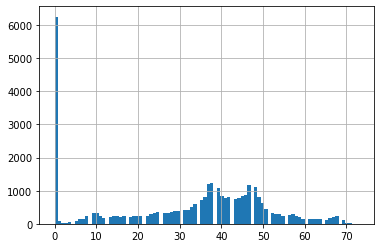

In [44]:
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

In [45]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

In [46]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
print(dfTrainsLearn['symbolType'].unique())

['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']


In [47]:
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W'])


In [48]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45.]


In [49]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [50]:
# routeLoca = dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].str.len() > 0]['aotuTrainData.routeLocationList']
# route = routeLoca.iloc[0]
# print(route)
# jsroute = pd.json_normalize(route)
# jsroute

In [51]:
# dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]
# dfTrainsLearn[dfTrainsLearn['aotuTrainData.routeLocationList'].apply(lambda x: isinstance(x, float))]['aotuTrainData.routeLocationList']

In [52]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [53]:
dfTrainsLearn['workLocations'].unique()

array([None, '225.10', '202.20', '202.20,219.70', '250.50,202.20', '258.40,202.20', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '202.20,314.52', '202.20,214.50,225.10,290.80,304.10',
       '214.50,225.10,290.80,304.10,202.20', '321.50,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '258.40,207.60,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,258.40,321.50,219.70', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [54]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [55]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [56]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-20T21:45:28Z,11,106,MAIN,765.4883
1,2022-06-20T21:47:28Z,14,106,MAIN-WEST MAIN,765.9972


In [57]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,764.8696,[]
0,764.9866,[]
0,764.9949,[]
0,764.8691,[]
0,764.9876,[]
...,...,...
0,318.4505,"[{'positionTime': '2022-06-23T11:50:55Z', 'speedMPH': 43, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 318.4505}}}, {'positionTime': '2022-06-23T11:52:55Z', 'speedMPH': 43, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 319.75415}}}, {'positionTime': '2022-06-23T11:54:55Z', 'speedMPH': 43, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 321.19598}}}, {'positionTime': '2022-06-23T11:56:55Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106..."
0,319.5837,"[{'positionTime': '2022-06-23T11:52:29Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 319.5837}}}, {'positionTime': '2022-06-23T11:54:29Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 320.99207}}}, {'positionTime': '2022-06-23T11:56:29Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 322.33743}}}, {'positionTime': '2022-06-23T11:58:29Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106..."
0,321.3070,"[{'positionTime': '2022-06-23T11:55:08Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 321.307}}}, {'positionTime': '2022-06-23T11:57:08Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 322.63477}}}, {'positionTime': '2022-06-23T11:59:08Z', 'speedMPH': 48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 324.12238}}}, {'positionTime': '2022-06-23T12:01:08Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."
0,322.5925,"[{'positionTime': '2022-06-23T11:57:09Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 322.5925}}}, {'positionTime': '2022-06-23T11:59:09Z', 'speedMPH': 46, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 323.9869}}}, {'positionTime': '2022-06-23T12:01:09Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 325.62582}}}, {'positionTime': '2022-06-23T12:03:09Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."


In [58]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [99]:
def findNextMilepost(trainsEntry, actualsEntry):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost+1]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost-1]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [121]:
def findNextSpeed(trainsEntry, actualsEntry):
  nextActual = findNextMilepost(trainsEntry, actualsEntry)
  if (len(nextActual) > 0):
    amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
    return amt;
  return None

In [123]:
idx = 3291
print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print(nextActual)
nextSpeed = findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print("actual speed: ",nextSpeed)
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop speed: ")
  value = findNextSpeed(dfTrainsLearn.iloc[idx], beopDT)
  print(value)
#   print('na')

UP2533
CWSWT9
Reported speed:  49
Reported MP:  283.9285
Reported Time:  2022-06-23T11:11:58Z
           positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-06-23T11:13:58Z        52                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 1                                 285.63345  
actual speed:  3
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-06-23T11:13:58Z        58                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 1                                 285.68976  
beop speed: 
9


In [124]:
dfTrainsLearnActuals.iloc[idx]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-23T11:13:58Z,52,106,MT 1,285.63345
1,2022-06-23T11:15:58Z,54,106,MT 1,287.41605
2,2022-06-23T11:17:58Z,54,106,MT 1,289.24710
3,2022-06-23T11:19:58Z,56,106,MT 1,291.12222
4,2022-06-23T11:21:58Z,56,106,MT 1,292.97012
...,...,...,...,...,...
27,2022-06-23T12:07:58Z,32,106,MT 1,320.58530
28,2022-06-23T12:09:58Z,29,106,MT 1,321.64260
29,2022-06-23T12:11:58Z,30,106,MT 1,322.65045
30,2022-06-23T12:13:58Z,34,106,MT 1,323.75595


In [125]:
dfTrainsLearn['nextSpeed'] = np.NaN
dfTrainsLearn['nextBeop'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextSpeed = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      nextBeop = findNextSpeed(trainsEntry, beopDT)
      if (nextBeop != None):
        dfTrainsLearn.at[i,'nextBeop'] = nextSpeed
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000


In [126]:
dfTrainsLearn['nextSpeed'].unique()

array([ nan,   4.,   9.,   8.,   2.,  -1.,  -4.,  -3.,  -2.,   1.,   0.,   3.,   6.,  10.,  13.,  11.,  15.,  12.,   5.,  16.,  21.,  14.,  17., -13.,  22.,  18.,  24.,  20.,  -7., -17.,  -6., -10.,
         7.,  -5., -11.,  25.,  27., -21.,  19., -19.,  -8.,  23.,  32.,  36., -12.,  -9., -22., -20., -14., -23.,  29.,  28., -26., -15., -18.,  26., -25.,  31.,  30., -41.,  34.,  33.,  40.,  38.,
        37., -33., -34., -16.,  41., -24.,  35., -28., -30.,  39.,  44.,  45.,  46., -32., -36.,  49.,  42.,  68.,  52.,  53., -31., -27., -40.,  43.,  50., -43.,  63., -29.,  48., -45.,  69.,  65.,
       -39., -35., -49., -55., -42., -38.,  51., -37., -47.])

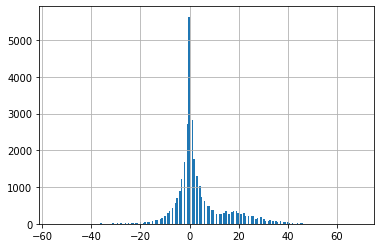

In [127]:
dfTrainsLearn['nextSpeed'].hist(bins=200)

In [128]:
dfTrainsLearn['nextBeop'].unique()

array([ nan,   1.,   4.,  16.,  21.,  14.,  17.,  -2., -13.,  12.,   6.,   2.,  -1.,   0.,  -4.,  -3.,  -7., -17.,  -5.,   3., -10., -11.,   7.,  18.,  10.,   5., -21.,  13.,  -6.,   9., -19.,  -8.,
        22., -12.,   8.,  11.,  -9., -22.,  15., -14., -23., -20.,  19., -26.,  20., -15., -18., -25.,  23.,  25., -41., -33., -34., -16.,  26.,  24.,  29., -24.,  31.,  32.,  27., -28., -30.,  30.,
        28., -32.,  33., -36.,  46.,  52.,  53., -31., -27., -40.,  38.,  43.,  45.,  40.,  39., -43.,  36.,  63.,  41., -29.,  48., -45.,  68.,  65.,  35., -39., -35., -49., -55., -42., -38.,  34.,
       -37., -47.])

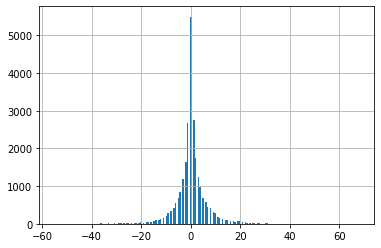

In [129]:
dfTrainsLearn['nextBeop'].hist(bins=200)

Drop some values we are not using at the moment not needed

In [130]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            # 'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            # 'lastReportedPosition.nextSignalState.previousSignalState', 
                                            # 'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [39]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
1,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
2,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
3,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
4,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
...,...,...,...,...,...,...,...,...,...
33627,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33628,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33629,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33630,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09


In [ ]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

# Use Decision Tree to predict speed in 1 mile

In [ ]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [ ]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


In [ ]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 176 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [ ]:
dep_var = 'nextSpeed'

In [ ]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [ ]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

In [ ]:
to.show()

In [ ]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [ ]:
to = fastai.load_pickle('/tmp/to.pkl')

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

In [ ]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs, y)

In [ ]:
m_rmse(m, valid_xs, valid_y)

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

In [ ]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [ ]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = randomForest(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
r_mse(preds.mean(0), valid_y)

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [ ]:
r_mse(m.oob_prediction_, y)

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

In [ ]:
print(preds.mean(0)[:10])
print(valid_y[:10])
valid_y

# FEATURE Importance

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:20]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [ ]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = randomForest(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

In [ ]:
fastai.cluster_columns(xs_imp)